In [3]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def gini_index(data: pd.DataFrame, class_column: int):
    prob = 0.0
    labels = data.iloc[:, class_column].value_counts(normalize=True)
    prob = sum(labels ** 2)
    return 1 - prob

def split_data(data: pd.DataFrame, column: int, value):
    column_name = data.columns[column]
    left = data[data[column_name] <= value]
    right = data[data[column_name] > value]
    return left, right

def get_best_split(data: pd.DataFrame, class_column: int):
    best_gini = 1
    best_split = None
    for column in range(data.shape[1] - 1):
        unique_values = data.iloc[:, column].unique()
        for value in unique_values:
            left, right = split_data(data, column, value)
            if len(left) == 0 or len(right) == 0:
                continue
            gini = (len(left) / len(data)) * gini_index(left, class_column) + (len(right) / len(data)) * gini_index(right, class_column)
            if gini < best_gini:
                best_gini = gini
                best_split = {'column': column, 'value': value, 'left': left, 'right': right}
    return best_split

class DecisionNode:
    def __init__(self, column=None, value=None, left=None, right=None, result=None):
        self.column = column
        self.value = value
        self.left = left
        self.right = right
        self.result = result

def build_tree(data: pd.DataFrame, class_column: int, max_depth=20, depth=0):
    target_column_name = data.columns[class_column]

    if depth >= max_depth or len(data[target_column_name].unique()) == 1:
        result = data[target_column_name].mode()[0]
        return DecisionNode(result=result)

    best_split = get_best_split(data, class_column)
    if not best_split:
        result = data[target_column_name].mode()[0]
        return DecisionNode(result=result)

    left_branch = build_tree(best_split['left'], class_column, max_depth, depth + 1)
    right_branch = build_tree(best_split['right'], class_column, max_depth, depth + 1)
    return DecisionNode(column=best_split['column'], value=best_split['value'], left=left_branch, right=right_branch)

def predict(node, row):
    if node.result is not None:
        return node.result
    if row.iloc[node.column] <= node.value:
        return predict(node.left, row)
    else:
        return predict(node.right, row)

def classify(tree, test_data):
    predictions = [predict(tree, row) for _, row in test_data.iterrows()]
    return predictions

def print_tree(node, depth=0):
    if node.result is not None:
        print(f"{'|   ' * depth}Predict: {node.result}")
    else:
        print(f"{'|   ' * depth}[X{node.column} <= {node.value}]")
        print_tree(node.left, depth + 1)
        print_tree(node.right, depth + 1)

In [34]:
from graphviz import Digraph
from IPython.display import Image, display

def visualize_tree(node, dot=None, column_names=None):
    if dot is None:
        dot = Digraph()
        dot.node(name=str(id(node)), label="Root")

    if node.result is not None:
        dot.node(name=str(id(node)), label=f"Predict: {node.result}", shape="box", style="filled", color="lightgrey")
    else:
        column_name = column_names[node.column]
        dot.node(name=str(id(node)), label=f"[{column_name} <= {node.value}]")

        if node.left:
            dot.edge(str(id(node)), str(id(node.left)), label="True")
            visualize_tree(node.left, dot, column_names)
        if node.right:
            dot.edge(str(id(node)), str(id(node.right)), label="False")
            visualize_tree(node.right, dot, column_names)

    return dot

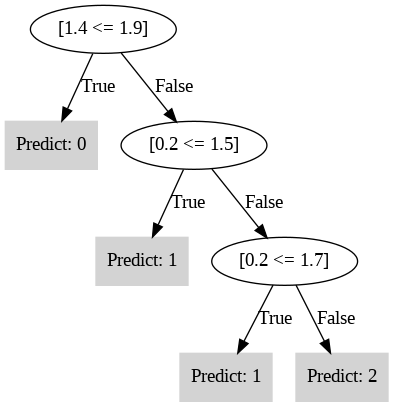

Accuracy: 0.9333333333333333
Precision: 0.9466666666666667
Recall: 0.9333333333333333
F1 Score: 0.9341798941798942


In [40]:
df = pd.read_csv("iris.csv", delimiter = ';')
X = df.iloc[:, :-1]
y = df.iloc[:, -1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
train_data = pd.concat([X_train, y_train], axis=1)
class_column = train_data.shape[1] - 1

tree = build_tree(train_data, class_column, max_depth=3)

# Visualize
column_names = X_train.columns.tolist()
dot = visualize_tree(tree, column_names=column_names)
dot.format = 'png'
dot.render('decision_tree')
display(Image('decision_tree.png'))

y_pred = classify(tree, X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

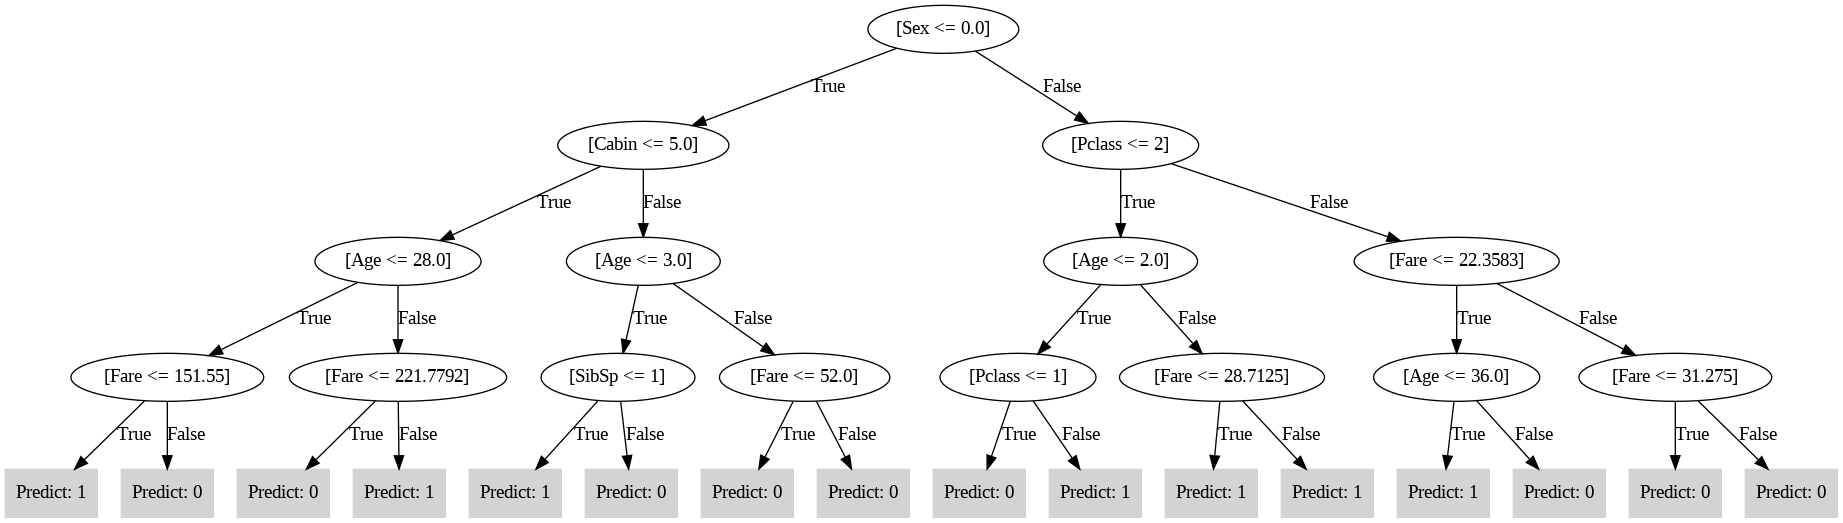

Accuracy: 0.8277153558052435
Precision: 0.83125596110452
Recall: 0.8277153558052435
F1 Score: 0.8244907769032026


In [28]:
df = pd.read_csv("titanic_preprocessed.csv", delimiter = ',')
X = df.drop(columns=['Survived', 'PassengerId'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

train_data = pd.concat([X_train, y_train], axis=1)
class_column = train_data.columns.get_loc('Survived')

tree = build_tree(train_data, class_column, max_depth=4)

# Visualize
column_names = X_train.columns.tolist()
dot = visualize_tree(tree, column_names=column_names)
dot.format = 'png'
dot.render('decision_tree')
display(Image('decision_tree.png'))

y_pred = classify(tree, X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

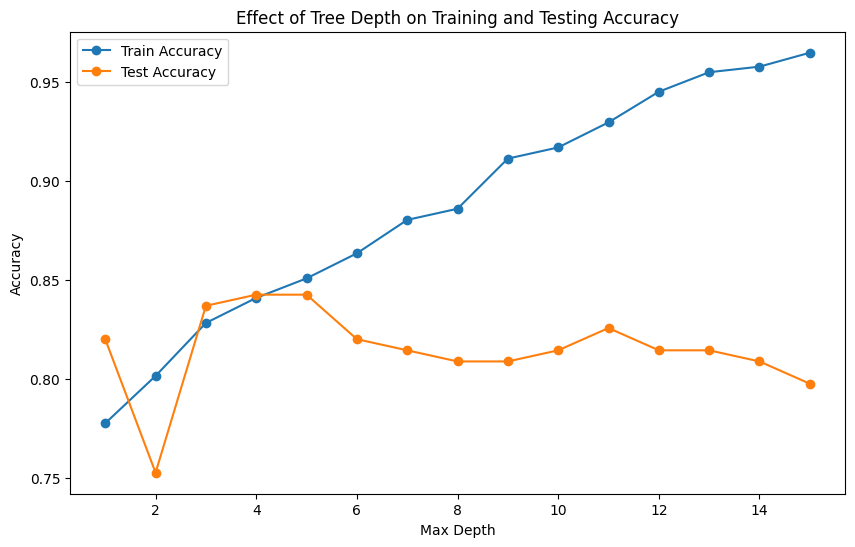

In [41]:
import matplotlib.pyplot as plt
data = pd.read_csv('titanic_preprocessed.csv', delimiter = ',')

X = data.drop(columns=['Survived', 'PassengerId'])
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

def evaluate_depths(X_train, y_train, X_test, y_test, max_depth_range=(1, 15)):
    train_accuracies = []
    test_accuracies = []

    for depth in range(max_depth_range[0], max_depth_range[1] + 1):
        train_data = X_train.copy()
        train_data['Survived'] = y_train
        test_data = X_test.copy()
        test_data['Survived'] = y_test

        tree = build_tree(train_data, class_column=train_data.columns.get_loc('Survived'), max_depth=depth)

        train_preds = classify(tree, X_train)
        test_preds = classify(tree, X_test)

        train_accuracy = accuracy_score(y_train, train_preds)
        test_accuracy = accuracy_score(y_test, test_preds)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return train_accuracies, test_accuracies

train_accuracies, test_accuracies = evaluate_depths(X_train, y_train, X_test, y_test)

depths = list(range(1, 16))
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(depths, test_accuracies, label="Test Accuracy", marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Effect of Tree Depth on Training and Testing Accuracy")
plt.legend()
plt.show()